In [14]:
import numpy as np

In [15]:
import sys

In [16]:
sys.path.append('/u/wangnisn/devel/Machine_learning_dynamics/bayesian')

In [17]:
import scipy
from scipy.io import loadmat
from data_generator import DataGenerator

In [18]:
from likelihood import GaussianLogLikelihood
from prior import ComplexityLogPrior
from posterior import LogPosterior
from mcmc import MCMC
from sequential_mc import SequentialMC
from util import generate_binary_coef_random
import pandas as pd

In [19]:
import matplotlib.pyplot as plt

In [20]:
data = loadmat('/u/wangnisn/devel/Machine_learning_dynamics/data/phase_field_oneD_simulation_beginning_stage.mat')

In [13]:
# calculate derivatives and prepare data
u = data['usol'][50:200,:]
x = np.squeeze(data['x'])[50:200]
t = np.squeeze(data['t'])[:]
from numerical_derivative import ChebyshevLocalFit_1D
width = 5                
du_x, du_xx, du_t = ChebyshevLocalFit_1D(u, x, t, deg=3, width=width, diff=2)
u = u[width:(-width), width:(-width)]

n_samples = 5000

u = u.flatten()
du_x = du_x.flatten()
du_xx = du_xx.flatten()
du_t = du_t.flatten()

data = np.vstack([u,du_x,du_xx, du_t]).T

#np.random.seed(1001)

#np.random.shuffle(data)
#data = data[:n_samples]

np.save('train_data_numerical_derivatives', data)

In [21]:
data = np.load('train_data_numerical_derivatives.npy')

In [22]:
dg = DataGenerator()

In [23]:
data[:,:-1].shape

(68600, 3)

In [35]:
X, names,complexities = dg(data[:,:-1], descriptions=['u','u_x','u_xx'],term_order_max=[4,2,1] )

In [36]:
X.shape

(68600, 21)

In [37]:
Y = data[:,-1]
#Y = -0.9*X[:,0] + 10.*X[:,2] +1.9*X[:,3] -1.*X[:,9]

In [38]:
prior = ComplexityLogPrior(method='num_terms', simplicity_preference=10.)

In [39]:
likelihood = GaussianLogLikelihood(X,Y,reg_normalization=False)

In [40]:
posterior = LogPosterior(prior, likelihood)

In [41]:
import itertools

In [42]:
init_coefs = generate_binary_coef_random(len(names),40)

In [43]:
sequentialmc = SequentialMC(posterior=posterior,log_file='mc.csv')

In [44]:
for i, name in enumerate(names):
    print (i, name)

0 1
1 u
2 u_x
3 u_xx
4 u**2
5 u*u_x
6 u*u_xx
7 u_x**2
8 u_x*u_xx
9 u**3
10 u**2*u_x
11 u**2*u_xx
12 u*u_x**2
13 u*u_x*u_xx
14 u_x**2*u_xx
15 u**4
16 u**3*u_x
17 u**3*u_xx
18 u**2*u_x**2
19 u**2*u_x*u_xx
20 u*u_x**2*u_xx


In [56]:
init_coefs[0] = np.array([0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0])

In [57]:
pareto_set = sequentialmc(samples=init_coefs,beta0_nsteps=0,beta0to1_nsteps=0,beta1_nsteps=0, mcmc_nsteps=10,feature_descriptions=names )

In [58]:
pareto_set = sequentialmc.pareto_set

In [59]:
array = pareto_set.to_array()

In [60]:
array

array([[1.00000000e+00, 3.10098245e-02],
       [2.00000000e+00, 1.22230387e-02],
       [3.00000000e+00, 9.50763059e-03],
       [4.00000000e+00, 1.26853898e-04],
       [1.20000000e+01, 1.53241662e-05]])

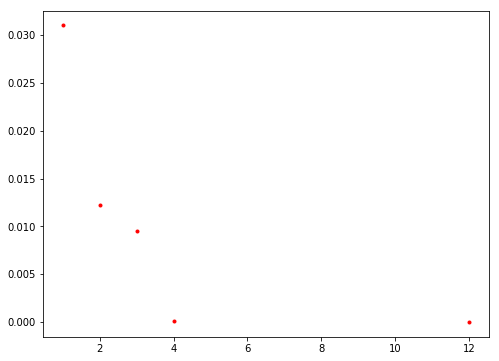

In [61]:
pareto_set.plot()

In [62]:
pareto_set[0].data

13.9834945806263*u*u_xx

In [63]:
pareto_set[1].data

6.3113881698941*u**2*u_x - 5.75619516484596*u_x

In [64]:
pareto_set[2].data

5.78525495164717*u**2*u_x + 0.58878069742667*u**2 - 0.569935034839501*u

In [65]:
pareto_set[3].data

-1.00752334442286*u**3 + 1.91098324840891*u**2 - 0.903562997322919*u + 10.3263096373328*u_xx

In [55]:
pareto_set[4].data

21.1647201175966*u**2*u_x + 0.516288859924315*u**2 + 99.1064342889429*u*u_xx - 0.514017077165506*u - 3.56114608671769*u_x

In [42]:
pareto_set[5].data

-1.0029908017627*u**3 + 1.90412649428831*u**2 - 0.901272418136458*u + 37.5667312918843*u_x*u_xx + 9.4270439158532*u_xx

In [43]:
pareto_set[6].data

-1.00287883115703*u**3 + 1.90376164131706*u**2 + 82.5100743234686*u*u_x*u_xx - 0.90101505086035*u + 242.346115909425*u_xx**2 + 9.39016420734836*u_xx

In [44]:
pareto_set.save_csv('pareto_set_simulation.csv')